In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# Loading Data
from google.colab import files
uploaded = files.upload()
wine = pd.read_csv(io.BytesIO(uploaded['winequalityN.csv']))
wine.head()

Saving winequalityN.csv to winequalityN (1).csv


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
data = wine.to_numpy()
print(data.shape)

X, y = data[:, :-1], data[:, -1]  # X has all the features of the wine, y is the wine's quality
print("The shape of X is", X.shape, "and X has", np.count_nonzero(pd.isnull(X)), "missing data entries.")

print("The shape of X's first column (non-numerical values) is", X[:, 0].shape, "and X's first column has", np.count_nonzero(pd.isnull(X[:, 0])), "missing data entries.")  # The first column of X has non-numerical values
X[:, 0] = (X[:, 0] == "red").astype(int)  # Convert non-numerical values to numerical values: 0->"white", 1->"red"

print("The shape of y is", y.shape, "and y has", np.count_nonzero(pd.isnull(y)), "missisng data entries.")
print()

# Mean-Based Imputation
print("------------------------- Mean-Based Imputation -------------------------")
X_mean_imp = X.copy();
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean_imp[:, 1:] = mean_imp.fit_transform(X_mean_imp[:, 1:])
print("The shape of X_mean_imp is", X_mean_imp.shape, "and X_mean_imp has", np.count_nonzero(pd.isnull(X_mean_imp)), "missing data entries.")
print()

# Regression-Based Imputation
print("------------------------- Regression-Based Imputation -------------------------")
X_reg_imp = X.copy();
reg_imp = IterativeImputer(missing_values=np.nan)
X_reg_imp[:, 1:] = reg_imp.fit_transform(X_reg_imp[:, 1:])
print("The shape of X_reg_imp is", X_reg_imp.shape, "and X_reg_imp has", np.count_nonzero(pd.isnull(X_reg_imp)), "missing data entries.")
print()


(6497, 13)
The shape of X is (6497, 12) and X has 38 missing data entries.
The shape of X's first column (non-numerical values) is (6497,) and X's first column has 0 missing data entries.
The shape of y is (6497,) and y has 0 missisng data entries.

------------------------- Mean-Based Imputation -------------------------
The shape of X_mean_imp is (6497, 12) and X_mean_imp has 0 missing data entries.

------------------------- Regression-Based Imputation -------------------------
The shape of X_reg_imp is (6497, 12) and X_reg_imp has 0 missing data entries.



---------------------- KNN ------------------------------------------
Averaged KNN (K = 1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.8851927610343452
Averaged KNN (K = 5 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.6758844860310206
Averaged KNN (K = 10 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.6577013019983317
Averaged KNN (K = 50 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.6705293032072437
Averaged KNN (K = 500 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.709265791397865
Averaged KNN (K = 1000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.7266520938374497
Averaged KNN (K = 2000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.7542083961309374


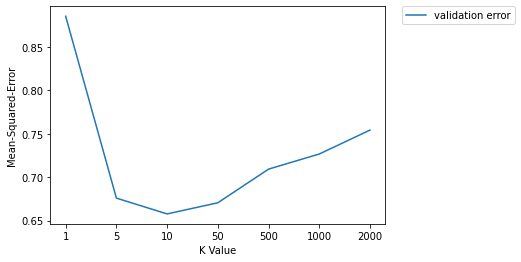

Test Mean-Squared-Error: 0.643928205128205


In [ ]:
# KNN Regression
# Splitting Datasets
random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("---------------------- KNN ------------------------------------------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

neighbors = [1, 5, 10, 50, 500, 1000, 2000]
errors_val = [0] * len(neighbors)
for i in range(len(neighbors)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    neigh = KNeighborsRegressor(n_neighbors=neighbors[i])
    neigh.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, neigh.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged KNN (K =", neighbors[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(neighbors)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel('K Value')
plt.xticks(range(len(neighbors)), neighbors)
plt.show()

# TESTING
# (Pick K = 10 since it has the least MSE)
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, neigh.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

In [ ]:
# Ordinary Least Squares
# Splitting Datasets
random_state = 13

colOnes = np.ones((X_reg_imp.shape[0], 1))
X_reg_imp_ones = np.hstack((colOnes, X_reg_imp))  # Stack a column of ones at the very first column

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp_ones, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("----------------------- OLS -------------------------------------------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

errorSum = 0
for train_index, test_index in kf.split(X_train_whole):
  X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
  y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]


  OLS = linear_model.LinearRegression(fit_intercept=False)
  OLS.fit(X_train, y_train)
  errorSum += mean_squared_error(y_val, OLS.predict(X_val))

errorAvg_val = errorSum / kf.get_n_splits()
print("Averaged OLS Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)

# TESTING
OLS = linear_model.LinearRegression(fit_intercept=False)
OLS.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, OLS.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

correct = 0
yy = np.round(OLS.predict(X_test))
for i in range(yy.shape[0]):
  if yy[i] == y_test[i]:
    correct += 1

print(correct)
print(yy.shape[0])
print(correct / yy.shape[0])

----------------------- OLS -------------------------------------------
Averaged OLS Mean-Squared-Error From 5 Fold Cross-Validation: 0.5285695889116699
Test Mean-Squared-Error: 0.5645996519829907
1046
1950
0.5364102564102564


Averaged Ridge Regression (lambda = 0.0001 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.534186991990568
Averaged Ridge Regression (lambda = 0.002 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5366366889787612
Averaged Ridge Regression (lambda = 0.005 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.540631140518922
Averaged Ridge Regression (lambda = 0.01 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5494316855666105
Averaged Ridge Regression (lambda = 0.02 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5714372852780015
Averaged Ridge Regression (lambda = 0.03 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5924720124349175
Averaged Ridge Regression (lambda = 0.04 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5958653604684397
Averaged Ridge Regression (lambda = 0.05 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5987160181684941
Averaged Ridge Regression (lambda = 0.1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5996502216538666


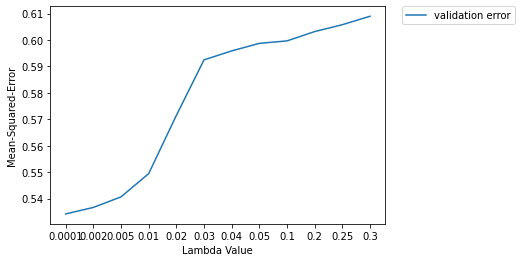

Test Mean-Squared-Error: 0.5667196341669235


In [ ]:
# Lasso Regression
# Splitting Datasets
random_state = 13

colOnes = np.ones((X_reg_imp.shape[0], 1))
X_reg_imp_ones = np.hstack((colOnes, X_reg_imp))  # Stack a column of ones at the very first column

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp_ones, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

# lambda_ = [0.000001, 0.000005, 0.00001, 0.00002, 0.000025, 0.00003, 0.00004, 0.00005]
lambda_ = [0.0001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.25, 0.3]
errors_val = [0] * len(lambda_)
for i in range(len(lambda_)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    lasso = linear_model.Lasso(alpha=lambda_[i], fit_intercept=False, max_iter=100000)
    lasso.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, lasso.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Lasso Regression (lambda =", lambda_[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(lambda_)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel('Lambda Value')
plt.xticks(range(len(lambda_)), lambda_)
plt.show()

# TESTING
# (Pick lambda = 0.0001 since it has the least MSE)
lasso = linear_model.Lasso(alpha=0.0001, fit_intercept=False, max_iter=100000)
lasso.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, lasso.predict(X_test))
print("Test Mean-Squared-Error:", error_test)


---------------------- Ridge ------------------------------------------
Averaged Ridge Regression (lambda = 0 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.528569588910473
Averaged Ridge Regression (lambda = 1e-06 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.528569023035523
Averaged Ridge Regression (lambda = 5e-06 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5285670136719369
Averaged Ridge Regression (lambda = 1e-05 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5285650580406622
Averaged Ridge Regression (lambda = 2e-05 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5285629049919726
Averaged Ridge Regression (lambda = 2.5e-05 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5285626599001644
Averaged Ridge Regression (lambda = 3e-05 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.528562938969659
Averaged Ridge Regression (lambda = 4e-05 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5285649847718352
Averaged Ridge Regression (lambda = 5

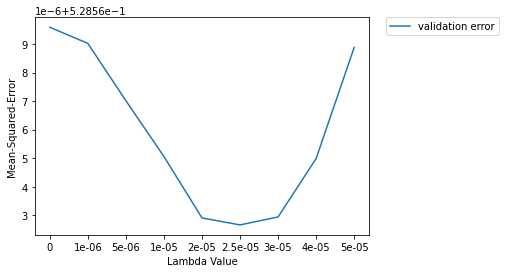

Test Mean-Squared-Error: 0.5645343829158954


In [ ]:
# Ridge Regression
# Splitting Datasets
random_state = 13

colOnes = np.ones((X_reg_imp.shape[0], 1))
X_reg_imp_ones = np.hstack((colOnes, X_reg_imp))  # Stack a column of ones at the very first column

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp_ones, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("---------------------- Ridge ------------------------------------------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

lambda_ = [0, 0.000001, 0.000005, 0.00001, 0.00002, 0.000025, 0.00003, 0.00004, 0.00005]
errors_val = [0] * len(lambda_)
for i in range(len(lambda_)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    ridge = linear_model.Ridge(alpha=lambda_[i], fit_intercept=False)
    ridge.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, ridge.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Ridge Regression (lambda =", lambda_[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(lambda_)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel('Lambda Value')
plt.xticks(range(len(lambda_)), lambda_)
plt.show()

# TESTING
# (Pick lambda = 0.000025 since it has the least MSE)
ridge = linear_model.Ridge(alpha=0.000025, fit_intercept=False)
ridge.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, ridge.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

In [ ]:
# Neural Networks (MLPRegressor)
# TODO: Tuning parameters
from sklearn.neural_network import MLPRegressor

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case


clf = MLPRegressor(activation='tanh', solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,5),max_iter=100000)
clf.fit(X_train_whole, y_train_whole.astype('int'))

error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

Test Mean-Squared-Error: 0.5409984271390784


In [ ]:
# Neural Networks (MLPClassifier)
# TODO: Tuning parameters
from sklearn.neural_network import MLPClassifier

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case


clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,5),max_iter=100000)
clf.fit(X_train_whole, y_train_whole.astype('int'))

error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

Test Mean-Squared-Error: 0.5994871794871794


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# # Neural Networks
# # Tuning Activation Functions

# random_state = 13

# # Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
# X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

# print("------------------- Neural Networks (Tuning Alpha) --------------------")
# # VALIDATION
# # Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
# kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

# activations = ['identity', 'logistic', 'tanh', 'relu']

# errors_val = [0] * len(activations)
# for i in range(len(activations)):
#   errorSum = 0
#   for train_index, test_index in kf.split(X_train_whole):
#     X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
#     y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

#     clf = MLPRegressor(activation=activations[i], solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,5),max_iter=100000) # 100000
#     clf.fit(X_train, y_train)
#     errorSum += mean_squared_error(y_val, clf.predict(X_val))

#   errorAvg_val = errorSum / kf.get_n_splits()
#   errors_val[i] = errorAvg_val
#   print("Averaged Neural Net (Activation Function =", activations[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


# plt.plot(range(len(activations)), errors_val, label = 'validation error')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# # plt.title('Regression on ' + str(i) + '% of the training data')
# plt.ylabel("Mean-Squared-Error")
# plt.xlabel('K Value')
# plt.xticks(range(len(activations)), activations)
# plt.show()

# # TESTING
# # (Pick alpha = 10 since it has the least MSE)
# clf = MLPRegressor(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 5, 5, 5),max_iter=100000,random_state=random_state)
# clf.fit(X_train_whole, y_train_whole)
# error_test = mean_squared_error(y_test, neigh.predict(X_test))
# print("Test Mean-Squared-Error:", error_test)


------------------- Neural Networks (Tuning Alpha) --------------------
Averaged Neural Net (Activation Function = identity ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5353893697866934


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


KeyboardInterrupt: ignored

------------------- Neural Networks (Tuning Alpha) --------------------
Averaged Neural Net (alpha = 0.1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5373967916151148
Averaged Neural Net (alpha = 1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5289843233014919
Averaged Neural Net (alpha = 3 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5440411364406952
Averaged Neural Net (alpha = 5 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5329937997681907
Averaged Neural Net (alpha = 10 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.559080637445478
Averaged Neural Net (alpha = 20 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5228653037994164
Averaged Neural Net (alpha = 30 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5222970480296081
Averaged Neural Net (alpha = 50 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5271111846498487


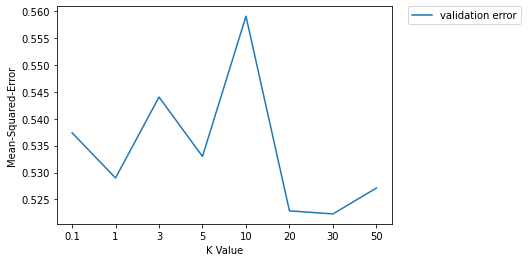

Test Mean-Squared-Error: 0.5684820512820513


In [ ]:
# Neural Networks
# Tuning Alpha

random_state = 22

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------------------- Neural Networks (Tuning Alpha) --------------------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

# alphas = [3, 4, 5, 6, 7, 8]
alphas = [0.1, 1, 3, 5, 10, 20, 30, 50]

errors_val = [0] * len(alphas)
for i in range(len(alphas)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    clf = MLPRegressor(solver='lbfgs', alpha=alphas[i],hidden_layer_sizes=(12,8,8,4,4),max_iter=100000,random_state=random_state)
    clf.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, clf.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Neural Net (alpha =", alphas[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(alphas)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel('K Value')
plt.xticks(range(len(alphas)), alphas)
plt.show()

# TESTING
# (Pick alpha = 10 since it has the least MSE)
clf = MLPRegressor(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 5, 5, 5),max_iter=100000,random_state=random_state)
clf.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, neigh.predict(X_test))
print("Test Mean-Squared-Error:", error_test)


------ Neural Networks (Tuning Number Of Layers In Neural Net) --------
Averaged Neural Net (Number Of Layers = 1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5251481676405126
Averaged Neural Net (Number Of Layers = 2 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5951657298735787
Averaged Neural Net (Number Of Layers = 3 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5158814965596911
Averaged Neural Net (Number Of Layers = 4 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5679072641171095
Averaged Neural Net (Number Of Layers = 5 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.7179537501437938


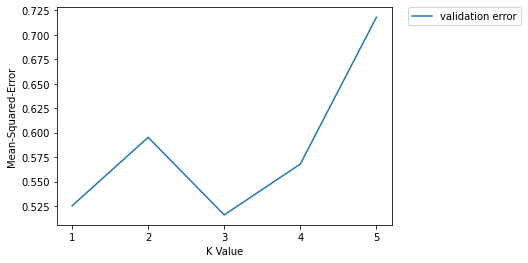

Test Mean-Squared-Error: 0.643928205128205


In [ ]:
# Neural Networks
# Tuning Number Of Layers In Neural Net

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Neural Networks (Tuning Number Of Layers In Neural Net) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

numLayers = [1, 2, 3, 4, 5]

errors_val = [0] * len(numLayers)
for i in range(len(numLayers)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = MLPRegressor(solver='lbfgs', alpha=10, hidden_layer_sizes=tuple([5]*numLayers[i]),max_iter=100000,random_state=random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Neural Net (Number Of Layers =", numLayers[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(numLayers)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel('K Value')
plt.xticks(range(len(numLayers)), numLayers)
plt.show()

# TESTING
# (Pick alpha = 10 since it has the least MSE)
regr = MLPRegressor(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 5, 5, 5),max_iter=100000,random_state=random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, neigh.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

In [ ]:
# Neural Networks
# Testing Early Stopping

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

# TESTING
# (Pick alpha = 10 since it has the least MSE)
regr = MLPRegressor(solver='sgd', alpha=10,hidden_layer_sizes=(5, 5, 5, 5),max_iter=100000,early_stopping=True,random_state=random_state)
regr.fit(X_train_whole, y_train_whole.astype('int'))
error_test = mean_squared_error(y_test, neigh.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

Test Mean-Squared-Error: 0.643928205128205


In [ ]:
# Neural Networks (MLPRegressor)
# Jacky's Experiment
from sklearn.neural_network import MLPRegressor

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case


clf = MLPRegressor(activation='relu', solver='lbfgs',alpha=20,hidden_layer_sizes=(12,8,8,4,4),max_iter=100000,random_state=22)
clf.fit(X_train_whole, y_train_whole.astype('int'))

error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Test Mean-Squared-Error:", error_test)
# 0.5443355227140089

Test Mean-Squared-Error: 0.5544292314290278


In [ ]:
# Neural Networks (MLPRegressor)
# Jacky's Experiment
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import  SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case


print('GradientBoostingRegressor ')
clf = GradientBoostingRegressor()
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)
clf1=clf

print('AdaBoostRegressor ')
clf = AdaBoostRegressor()
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)
clf2=clf

print('RandomForestRegressor ')
clf = RandomForestRegressor()
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)
clf3=clf

print('SGDRegressor ')
clf = SGDRegressor()
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

print('LogisticRegression ')
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train_whole, y_train_whole.astype('int'))
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

print('DecisionTreeRegressor ')
clf = DecisionTreeRegressor()
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

print('GaussianNB ')
clf = GaussianNB()
clf.fit(X_train_whole, y_train_whole.astype('int'))
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

print('SVM ')
clf = SVC()
clf.fit(X_train_whole, y_train_whole.astype('int'))
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

error_test = mean_squared_error(y_test, (clf1.predict(X_test)+clf3.predict(X_test))/2)
print(error_test)

GradientBoostingRegressor 
Train Mean-Squared-Error: 0.3910306007157775
Test Mean-Squared-Error: 0.4814557300124656
AdaBoostRegressor 
Train Mean-Squared-Error: 0.490103183582517
Test Mean-Squared-Error: 0.5561958300619848
RandomForestRegressor 
Train Mean-Squared-Error: 0.052352210248515496
Test Mean-Squared-Error: 0.3920474871794872
SGDRegressor 
Train Mean-Squared-Error: 5.529029005947007e+25
Test Mean-Squared-Error: 5.45918749113801e+25
LogisticRegression 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Mean-Squared-Error: 0.6283263690345282
Test Mean-Squared-Error: 0.662051282051282
DecisionTreeRegressor 
Train Mean-Squared-Error: 0.0
Test Mean-Squared-Error: 0.7194871794871794
GaussianNB 
Train Mean-Squared-Error: 1.2410380470639983
Test Mean-Squared-Error: 1.2107692307692308
SVM 
Train Mean-Squared-Error: 0.7901913349461184
Test Mean-Squared-Error: 0.803076923076923
0.4175869314229155


------ Gradient Boosting (Tuning Number Of Boosting Stages) --------
Averaged Gradient Boosting (Number Of Boosting Stages = 100 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.46943530473113404
Averaged Gradient Boosting (Number Of Boosting Stages = 200 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.45633949754061354
Averaged Gradient Boosting (Number Of Boosting Stages = 500 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4438073973536619
Averaged Gradient Boosting (Number Of Boosting Stages = 1000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.43896361589177557
Averaged Gradient Boosting (Number Of Boosting Stages = 2000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.444377210219733
Averaged Gradient Boosting (Number Of Boosting Stages = 5000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4588183052511445


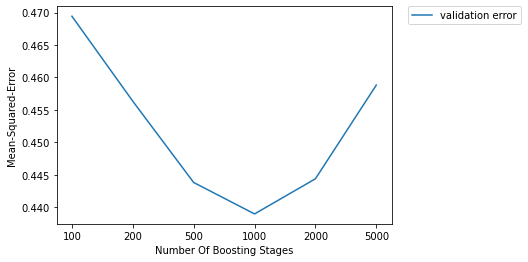

Test Mean-Squared-Error: 0.44370084049561476


In [ ]:
# Gradient Boosting
# Tuning Number Of Boosting Stages

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Gradient Boosting (Tuning Number Of Boosting Stages) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

numStages = [100, 200, 500, 1000, 2000, 5000]

errors_val = [0] * len(numStages)
for i in range(len(numStages)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = GradientBoostingRegressor(n_estimators=numStages[i], max_features="sqrt", random_state = random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Gradient Boosting (Number Of Boosting Stages =", numStages[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(numStages)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel("Number Of Boosting Stages")
plt.xticks(range(len(numStages)), numStages)
plt.show()

# TESTING
# (Pick n_estimators = 1000 since it has the least MSE)
regr = GradientBoostingRegressor(n_estimators=1000, max_features="sqrt", random_state = random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, regr.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

------ Gradient Boosting (Tuning Maximum Depth) --------
Averaged Gradient Boosting (Maximum Depth = 3 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.46943530473113404
Averaged Gradient Boosting (Maximum Depth = 7 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4164115960553148
Averaged Gradient Boosting (Maximum Depth = 11 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4003450568929714
Averaged Gradient Boosting (Maximum Depth = 15 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.393942428470707
Averaged Gradient Boosting (Maximum Depth = 19 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3911907330067865
Averaged Gradient Boosting (Maximum Depth = 23 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3920373247036871
Averaged Gradient Boosting (Maximum Depth = 27 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3961138346496852
Averaged Gradient Boosting (Maximum Depth = 31 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4020391397073383


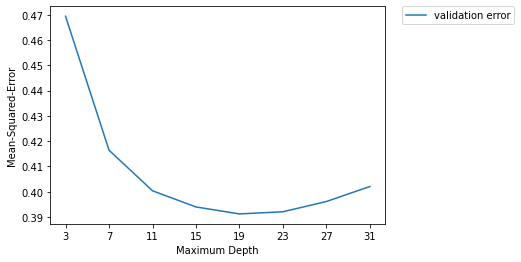

Test Mean-Squared-Error: 0.3748065238547594


In [ ]:
# Gradient Boosting
# Tuning Maximum Depth

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Gradient Boosting (Tuning Maximum Depth) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

depths = [3, 7, 11, 15, 19, 23, 27, 31]

errors_val = [0] * len(depths)
for i in range(len(depths)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = GradientBoostingRegressor(max_depth=depths[i], max_features="sqrt", random_state = random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Gradient Boosting (Maximum Depth =", depths[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(depths)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel("Maximum Depth")
plt.xticks(range(len(depths)), depths)
plt.show()

# TESTING
# (Pick max_depth = 19 since it has the least MSE)
regr = GradientBoostingRegressor(max_depth=19, max_features="sqrt", random_state = random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, regr.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

------ Gradient Boosting (Tuning Minimum Number Of Samples Required To Be At A Leaf Node) --------
Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node = 1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.46943530473113404
Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node = 5 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.46734482429211816
Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node = 6 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4673488462911661
Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node = 7 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4672231108950027
Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node = 8 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4652522807301677
Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node = 9 ) Mean-Squared-Error 

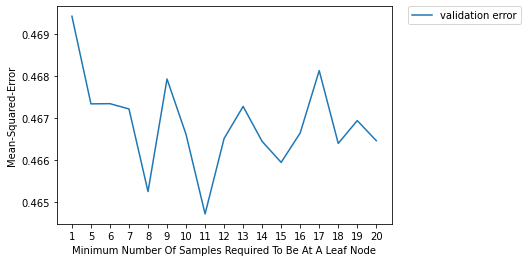

Test Mean-Squared-Error: 0.48436539591615985


In [ ]:
# Gradient Boosting
# Tuning Minimum Number Of Samples Required To Be At A Leaf Node

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Gradient Boosting (Tuning Minimum Number Of Samples Required To Be At A Leaf Node) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

minSamples = [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

errors_val = [0] * len(minSamples)
for i in range(len(minSamples)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = GradientBoostingRegressor(min_samples_leaf=minSamples[i], max_features="sqrt", random_state = random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Gradient Boosting (Minimum Number Of Samples Required To Be At A Leaf Node =", minSamples[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(minSamples)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel("Minimum Number Of Samples Required To Be At A Leaf Node")
plt.xticks(range(len(minSamples)), minSamples)
plt.show()

# TESTING
# (Pick min_samples_leaf = 11 since it has the least MSE)
regr = GradientBoostingRegressor(min_samples_leaf=11, max_features="sqrt", random_state = random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, regr.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

In [ ]:
print('GradientBoostingRegressor (Best Parameters)')

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

clf = GradientBoostingRegressor(min_samples_leaf=11, n_estimators=10000, max_depth=19, max_features="sqrt")
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

GradientBoostingRegressor (Best Parameters)
Train Mean-Squared-Error: 9.975869942639488e-08
Test Mean-Squared-Error: 0.38498377790383154


------ Random Forest (Tuning Number Of Trees) --------
Averaged Random Forest (Number Of Trees = 100 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3877596289848765
Averaged Random Forest (Number Of Trees = 200 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.38710975197354897
Averaged Random Forest (Number Of Trees = 500 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3849891903499801
Averaged Random Forest (Number Of Trees = 1000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3838191114604867
Averaged Random Forest (Number Of Trees = 2000 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.38305722517952345


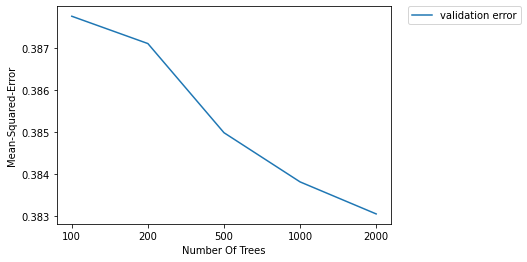

Test Mean-Squared-Error: 0.37155620384615384


In [ ]:
# Random Forest
# Tuning Number Of Trees

# print('RandomForestRegressor ')
# clf = RandomForestRegressor()
# clf.fit(X_train_whole, y_train_whole)
# error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
# error_test = mean_squared_error(y_test, clf.predict(X_test))
# print("Train Mean-Squared-Error:", error_train)
# print("Test Mean-Squared-Error:", error_test)

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Random Forest (Tuning Number Of Trees) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

numTrees = [100, 200, 500, 1000, 2000]

errors_val = [0] * len(numTrees)
for i in range(len(numTrees)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = RandomForestRegressor(n_estimators=numTrees[i], max_features="sqrt", random_state = random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Random Forest (Number Of Trees =", numTrees[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(numTrees)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel("Number Of Trees")
plt.xticks(range(len(numTrees)), numTrees)
plt.show()

# TESTING
# (Pick n_estimators = 2000 since it has the least MSE)
regr = RandomForestRegressor(n_estimators=2000, max_features="sqrt", random_state = random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, regr.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

------ Random Forest (Tuning Maximum Depth) --------
Averaged Random Forest (Maximum Depth = 3 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5681205104106608
Averaged Random Forest (Maximum Depth = 7 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4763468945841403
Averaged Random Forest (Maximum Depth = 11 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4191309240373881
Averaged Random Forest (Maximum Depth = 15 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.396641048409926
Averaged Random Forest (Maximum Depth = 19 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.39003487900810996
Averaged Random Forest (Maximum Depth = 23 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3871024452715593
Averaged Random Forest (Maximum Depth = 27 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3871577333860735
Averaged Random Forest (Maximum Depth = 31 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3876523855750637
Averaged Random Forest (Maximum Depth = 35 ) 

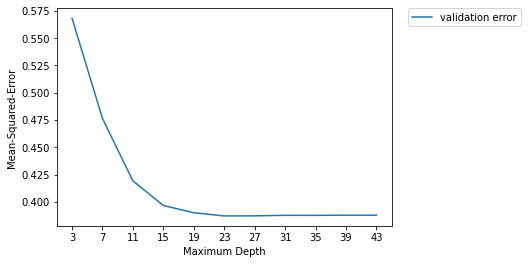

Test Mean-Squared-Error: 0.3780063469586372


In [ ]:
# Random Forest
# Tuning Maximum Depth

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Random Forest (Tuning Maximum Depth) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

depths = [3, 7, 11, 15, 19, 23, 27, 31]

errors_val = [0] * len(depths)
for i in range(len(depths)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = RandomForestRegressor(max_depth=depths[i], max_features="sqrt", random_state = random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Random Forest (Maximum Depth =", depths[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(depths)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel("Maximum Depth")
plt.xticks(range(len(depths)), depths)
plt.show()

# TESTING
# (Pick max_depth = 23 since it has the least MSE)
regr = RandomForestRegressor(max_depth=23, max_features="sqrt", random_state = random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, regr.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

------ Random Forest (Tuning Minimum Number Of Samples Required To Be At A Leaf Node) --------
Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node = 1 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.3877596289848765
Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node = 5 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4256963511859132
Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node = 10 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.4502708587309826
Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node = 50 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5081002700153253
Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node = 100 ) Mean-Squared-Error From 5 Fold Cross-Validation: 0.5354966143867134
Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node = 200 ) Mean-Squared-Error From 5 Fold Cross-Valida

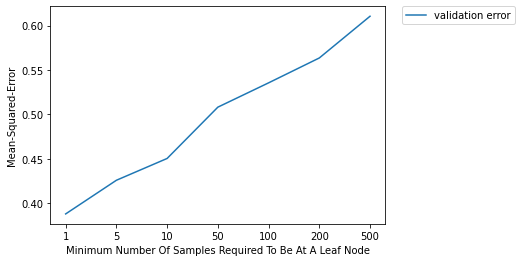

Test Mean-Squared-Error: 0.3748045641025641


In [ ]:
# Random Forest
# Tuning Minimum Number Of Samples Required To Be At A Leaf Node

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

print("------ Random Forest (Tuning Minimum Number Of Samples Required To Be At A Leaf Node) --------")
# VALIDATION
# Use k-fold cross-validation to split X_train_whole into X_train and X_val, and also split y_train_whole into y_train and y_val.
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)  # 5-fold

minSamples = [1, 5, 10, 50, 100, 200, 500]

errors_val = [0] * len(minSamples)
for i in range(len(minSamples)):
  errorSum = 0
  for train_index, test_index in kf.split(X_train_whole):
    X_train, X_val = X_train_whole[train_index], X_train_whole[test_index]
    y_train, y_val = y_train_whole[train_index], y_train_whole[test_index]

    regr = RandomForestRegressor(min_samples_leaf=minSamples[i], max_features="sqrt", random_state = random_state)
    regr.fit(X_train, y_train)
    errorSum += mean_squared_error(y_val, regr.predict(X_val))

  errorAvg_val = errorSum / kf.get_n_splits()
  errors_val[i] = errorAvg_val
  print("Averaged Random Forest (Minimum Number Of Samples Required To Be At A Leaf Node =", minSamples[i], ") Mean-Squared-Error From", kf.get_n_splits(), "Fold Cross-Validation:", errorAvg_val)


plt.plot(range(len(minSamples)), errors_val, label = 'validation error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.title('Regression on ' + str(i) + '% of the training data')
plt.ylabel("Mean-Squared-Error")
plt.xlabel("Minimum Number Of Samples Required To Be At A Leaf Node")
plt.xticks(range(len(minSamples)), minSamples)
plt.show()

# TESTING
# (Pick min_samples_leaf = 1 since it has the least MSE)
regr = RandomForestRegressor(min_samples_leaf=1, max_features="sqrt", random_state = random_state)
regr.fit(X_train_whole, y_train_whole)
error_test = mean_squared_error(y_test, regr.predict(X_test))
print("Test Mean-Squared-Error:", error_test)

In [ ]:
print('RandomForestRegressor (Best Parameters)')

random_state = 13

# Jacky's note: enable stratify here since we want to preserve the proportions of red and white wines in both the training and testing sets?
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X_reg_imp, y, stratify=y, test_size=0.3, random_state=random_state)  # Using the regression-based imputed dataset in this case

clf = RandomForestRegressor(n_estimators=2000, max_depth=23, max_features="sqrt")
clf.fit(X_train_whole, y_train_whole)
error_train = mean_squared_error(y_train_whole, clf.predict(X_train_whole))
error_test = mean_squared_error(y_test, clf.predict(X_test))
print("Train Mean-Squared-Error:", error_train)
print("Test Mean-Squared-Error:", error_test)

# correct = 0
# yy = np.round(clf.predict(X_test))
# for i in range(yy.shape[0]):
#   if yy[i] == y_test[i]:
#     correct += 1

# print("number of correct predictions: ", correct)
# print("number of total predictions: ", yy.shape[0])
# print("fraction of correct predictions: ", correct / yy.shape[0])

RandomForestRegressor (Best Parameters)
Train Mean-Squared-Error: 0.050163492612288835
Test Mean-Squared-Error: 0.37346927677008923
1327
1950
0.6805128205128205
